### Run Inference
Let's run inference.

In [1]:
from eval import *
from yolact_edge.utils.logging_helper import setup_logger

parse_args(["--config=yolact_edge_config", "--calib_images=../calib_images"]) 

from eval import args

setup_logger(logging_level=logging.INFO)
logger = logging.getLogger("yolact.eval")

/home/saicharanm22/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


We initialize the network and load a pre-trained model.

In [ ]:
args.trained_model = "./weights/yolact_edge_54_800000.pth"
args.yolact_transfer = True

torch.set_default_tensor_type('torch.cuda.FloatTensor')

logger.info('Loading model...')
net = Yolact(training=False)
net.load_weights(args.trained_model, args=args)
net.eval()
logger.info('Model loaded.')

net.detect.use_fast_nms = args.fast_nms
cfg.mask_proto_debug = args.mask_proto_debug

args.score_threshold = 0.15
args.top_k = 15

We first download an image from the COCO dataset:

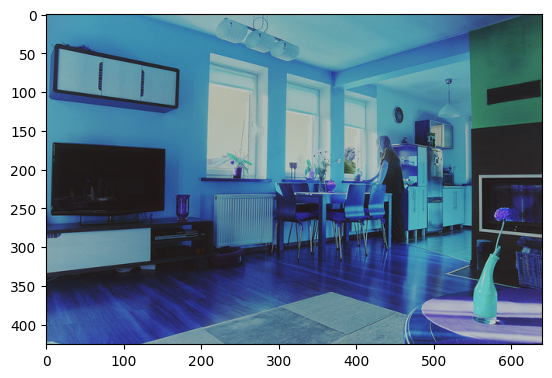

In [2]:
import cv2

im = cv2.imread("./data/coco/images/000000000150.jpg")
import matplotlib.pyplot as plt

plt.imshow(im)

Then, we create load that frame to GPU and run inference on this image.

In [ ]:
frame = torch.from_numpy(im).cuda().float()
batch = FastBaseTransform()(frame.unsqueeze(0))

extras = {"backbone": "full", "interrupt": False, "keep_statistics": False,
          "moving_statistics": None}

with torch.no_grad():
    preds = net(batch, extras=extras)["pred_outs"]

In [ ]:
# Look at the output predictions.

dets = preds[0]

print('Scores:', dets['score'][:args.top_k])
print('Classes:', dets['class'][:args.top_k])
print('Boxes:', dets['box'][:args.top_k])

In [ ]:
# Visualize the predictions

img_numpy = prep_display(preds, frame, None, None, undo_transform=False)

cv2_imshow(img_numpy)

Tests

In [9]:
!python3 eval.py --trained_model=./weights/yolact_edge_vid_847_50000.pth --disable_tensorrt --dataset coco2017_dataset 

/home/saicharanm22/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Config not specified. Parsed yolact_edge_vid_config from the file name.

[04/14 16:48:53 yolact.eval]: Loading model...
[04/14 16:48:55 yolact.eval]: Model loaded.
[ WARN:0@3.746] global loadsave.cpp:244 findDecoder imread_('./data/coco/images/000000000150.jpg'): can't open/read file: check file path/integrity
Traceback (most recent call last):
  File "/data1/saicharanm22/yolact_edge_lwf/eval.py", line 1280, in <module>
    evaluate(net, dataset)
  File "/data1/saicharanm22/yolact_edge_lwf/eval.py", line 907, in evaluate
    evalimage(net, args.image, detections=detections, image_id="0")
  File "/data1/saicharanm22/yolact_edge_lwf/eval.py", line 588, in evalimage
    frame = torch.from_numpy(cv2.imread(path)).cuda().float()
TypeError: expected np.ndarray (got NoneType)


In [ ]:
!python3 eval.py --trained_model=./weights/yolact_edge_54_800000.pth    # with 20mb inferences_val2007 file